In [4]:
import numpy as np
import matplotlib.pyplot as plt
import george
from george import kernels
%matplotlib inline
from astropy.table import Table
from george.modeling import Model
import pymc3 as pm
#import tensorflow as tf

In [5]:
tab = Table.read('Data/SN1987A_photometry.csv',format='ascii')
band = tab['band']
time = tab['time']
mag = tab['magnitude']
band_name = np.unique(band)
tab

event,time,magnitude,e_magnitude,upperlimit,band,instrument,telescope,source
str7,float64,float64,int64,int64,str1,int64,int64,str104
SN1987A,46849.44,6.36,--,--,V,--,--,"1987IAUC.4495....1M,Sternberg Astronomical Institute Supernova Light Curve Catalogue"
SN1987A,46849.62,6.11,--,--,V,--,--,"1987IAUC.4495....1M,Sternberg Astronomical Institute Supernova Light Curve Catalogue"
SN1987A,46850.45,4.89,--,--,B,--,--,"1987IAUC.4313....1M,Sternberg Astronomical Institute Supernova Light Curve Catalogue"
SN1987A,46850.45,4.06,--,--,U,--,--,"1987IAUC.4313....1M,Sternberg Astronomical Institute Supernova Light Curve Catalogue"
SN1987A,46850.45,4.81,--,--,V,--,--,"1987IAUC.4313....1M,Sternberg Astronomical Institute Supernova Light Curve Catalogue"
SN1987A,46850.8,4.74,--,--,B,--,--,"1987IAUC.4320....1F,Sternberg Astronomical Institute Supernova Light Curve Catalogue"
SN1987A,46850.8,4.29,--,--,I,--,--,"1987IAUC.4320....1F,Sternberg Astronomical Institute Supernova Light Curve Catalogue"
SN1987A,46850.8,4.37,--,--,R,--,--,"1987IAUC.4320....1F,Sternberg Astronomical Institute Supernova Light Curve Catalogue"
SN1987A,46850.8,3.95,--,--,U,--,--,"1987IAUC.4320....1F,Sternberg Astronomical Institute Supernova Light Curve Catalogue"


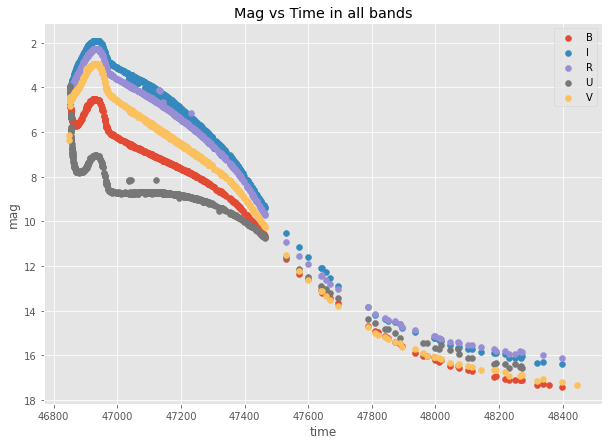

In [6]:
plt.style.use('ggplot')
plt.figure(figsize = (10,7))
for i in range(len(band_name)):
    plt.scatter(time[band == band_name[i]], mag[band == band_name[i]], label = str(band_name[i]))
    plt.legend()
plt.title("Mag vs Time in all bands")
plt.xlabel("time") 
plt.ylabel("mag")
plt.gca().invert_yaxis()

In [7]:
mask = (time>46800) & (time < 47200)
mtab = tab[mask]
mtime = mtab['time']
mmag = mtab['magnitude']
mband = mtab['band']
min_time = np.min(mtime)
mtime = mtime - min_time # to make time start from zero

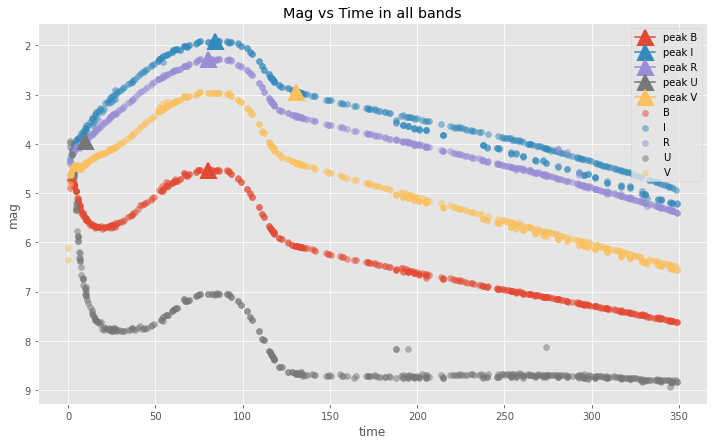

In [8]:
plt.style.use('ggplot')
plt.figure(figsize = (12,7))
for i in range(len(band_name)):
    plt.scatter(mtime[mband == band_name[i]], mmag[mband == band_name[i]], label = str(band_name[i]), alpha = 0.5)
    #min_index = np.argmin(mmag[mband == band_name[i]])
    min_mag = np.min(mmag[mband == band_name[i]])
    plt.plot(np.median(mtime[mmag == min_mag]), min_mag , marker ='^', label = 'peak ' + str(band_name[i]), ms=15.,  mew=2)
    plt.legend(loc = 'best')
plt.title("Mag vs Time in all bands")
plt.xlabel("time") 
plt.ylabel("mag")
plt.gca().invert_yaxis()


In [9]:
class mean_model(Model):
    parameter_names = ("a1", "b1", "c1","a2", "b2", "c2" )
    
    def get_value(self, t):
        magnitude = []
        for x in t:
            if x < 115:
                magnitude.append(self.a1*x**2 + self.b1*x + self.c1)
            else:
                magnitude.append(self.a2*x**2 + self.b2*x + self.c2)
        return np.array(magnitude)

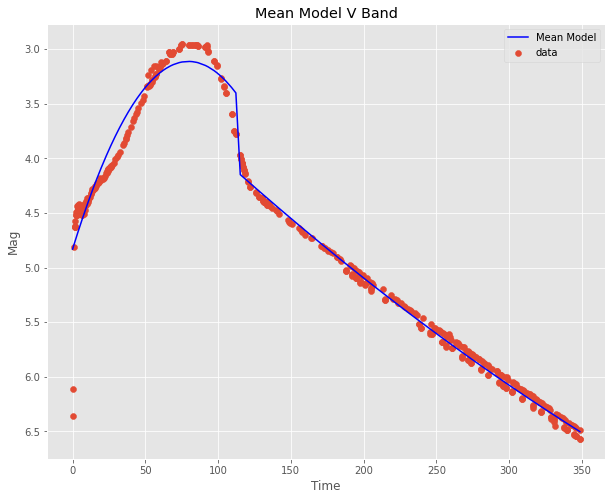

In [10]:
v_mtime = np.asarray(mtime[mband == 'V'])
v_mmag =  np.asarray(mmag[mband == 'V'])
A1,B1,C1 = np.polyfit(v_mtime[v_mtime<115], v_mmag[v_mtime<115], 2)
A2,B2,C2  = np.polyfit(v_mtime[v_mtime>115], v_mmag[v_mtime>115], 2)
model_flux = mean_model(a1=A1, b1= B1, c1=C1, a2=A2, b2=B2, c2=C2).get_value(v_mtime)

#plot the model on top of the original data  
plt.style.use("ggplot")
plt.figure(figsize=(10,8))
plt.scatter(v_mtime, v_mmag, label = "data")
plt.plot(v_mtime, model_flux,'b-', label = "Mean Model")
plt.title('Mean Model V Band')
plt.xlabel("Time")
plt.ylabel("Mag")
plt.legend(loc='best')
plt.gca().invert_yaxis()

[ 2.71116252e-04 -4.31769322e-02  4.83143624e+00 -7.30072808e-06
  1.34684156e-02  2.69319695e+00  4.24849524e+00]


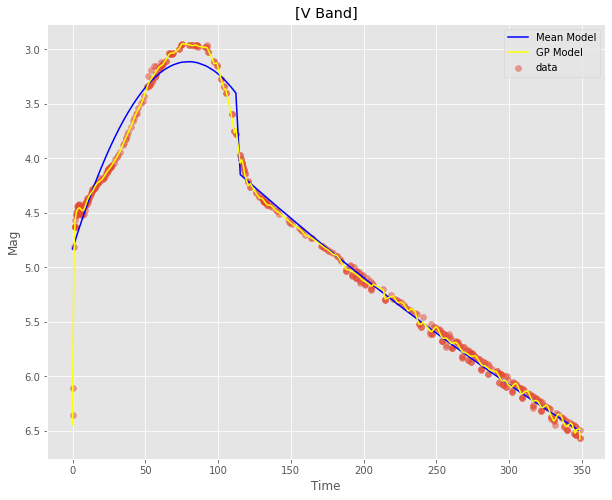

In [11]:
MEAN = mean_model(a1=A1, b1= B1, c1=C1, a2=A2, b2=B2, c2=C2)
k = kernels.ExpSquaredKernel(70.0)

gp = george.GP(k, mean = MEAN)
gp.compute(v_mtime)

print(gp.get_parameter_vector())


mu,var = gp.predict(v_mmag,v_mtime,return_var=True)


plt.style.use("ggplot")
plt.figure(figsize=(10,8))
plt.scatter(v_mtime, v_mmag, label = "data", alpha = 0.5)
plt.plot(v_mtime, model_flux,'b-', label = "Mean Model")
plt.plot(v_mtime, mu, color="yellow", label = 'GP Model ')
plt.title('[V Band]')
plt.xlabel("Time")
plt.ylabel("Mag")
plt.legend(loc='best')
plt.gca().invert_yaxis()



In [12]:
#The mean function is the same as before but its rewritten in a format that is acceptable by the gp.marginal function
import theano.tensor as tt
import pymc3 as pm

class MeanModel(pm.gp.mean.Mean):

    def __init__(self, a1,b1,c1,a2,b2,c2):
        self.a1 = a1
        self.b1 = b1
        self.c1 = c1
        self.a2 = a2
        self.b2 = b2
        self.c2 = c2
        
    def __call__(self, t):
        t = np.array(t)
        peak_t = 115
        rise_t = t[t <= PT]
        fall_t = t[t > PT]
        rise_mag = self.a1*rise_t**2 + self.b1*rise_t + self.c1
        fall_mag = self.a1*fall_t**2 + self.b1*fall_t + self.c1
        mean_mag = tt.concatenate([rise_mag, fall_mag])
        return mean_mag


In [13]:
X =v_mtime[:,None]
Y = v_mmag


In [17]:
with pm.Model() as marginal_gp_model:
    # Specify the covariance function.
    cov_func = pm.gp.cov.ExpQuad(input_dim=1, ls=50)
    
#     aa1 = pm.Normal('aa1', mu=A1, sigma=A1*1e-1, shape=1)
#     bb1 = pm.Normal('bb1', mu=B1, sigma=B1*1e-1, shape=1)
#     cc1 = pm.Normal('cc1', mu=C1, sigma=C1*1e-1, shape=1)
#     aa2 = pm.Normal('aa2', mu=A2, sigma=A2*1e-1, shape=1)
#     bb2 = pm.Normal('bb2', mu=B2, sigma=B2*1e-1, shape=1)
#     cc2 = pm.Normal('cc2', mu=C2, sigma=C2*1e-1, shape=1)
    
    #turn = pm.Normal('turn', p0[6], sigma=1, shape=1)
    # Specify the GP.  The default mean function is `Zero`.
    #MEAN = Mean_Function(a1=aa1, b1= bb1, c1=cc1, a2=aa2, b2=bb2, c2=cc2)
    MEAN = MeanModel(A1,B1,C1,A2,B2,C2)
    gp = pm.gp.Marginal(cov_func=cov_func, mean_func = MEAN)

    # The scale of the white noise term can be provided,
    sigma = pm.HalfCauchy("sigma", beta=5)
    y_ = gp.marginal_likelihood("y", X=X, y=Y, noise=sigma)
    MAP =  pm.find_MAP()

NameError: name 'PT' is not defined

In [ ]:
X_new = np.linspace(0, np.max(X),100)#[:,None]

# add the GP conditional to the model, given the new X values
with marginal_gp_model:
    X_pred = gp.conditional("X_pred", X_new)

#To use the MAP values, you can just replace the trace with a length-1 list with `mp`

with marginal_gp_model:
    pred_samples = pm.sample_posterior_predictive([MAP], vars=[f_pred],samples=50)

In [ ]:
# #The mean function is the same as before but its rewritten in a format that is acceptable by the gp.marginal function
# class Mean_Function(pm.gp.mean.Mean):

#     def __init__(self, a1,b1,c1,a2,b2,c2):
#         self.a1 = a1
#         self.b1 = b1
#         self.c1 = c1
#         self.a2 = a2
#         self.b2 = b2
#         self.c2 = c2

#     def __call__(self, t):
#         magnitude = []
#         for x in t:
#             if x < 115:
#                 magnitude.append(self.a1*x**2 + self.b1*x + self.c1)
#             else:
#                 magnitude.append(self.a2*x**2 + self.b2*x + self.c2)
#         return np.array(magnitude)

In [ ]:

# # A one dimensional column vector of inputs.
# X = np.array(v_mtime)[np.newaxis].T
# #Y = np.array(v_mmag)[np.newaxis].T

# with pm.Model() as marginal_gp_model:
#     # Specify the covariance function.
#     cov_func = pm.gp.cov.ExpQuad(1, ls=0.1)

#     # Specify the GP.
#     MEAN = Mean_Function(a1=A1, b1= B1, c1=C1, a2=A2, b2=B2, c2=C2)
#     gp = pm.gp.Marginal( cov_func=cov_func, mean_func = MEAN)

#     # The scale of the white noise term can be provided,
#     sigma = pm.HalfCauchy("sigma", beta=5)
#     y_ = gp.marginal_likelihood("y", X=X, y=v_mmag, noise=sigma)

In [ ]:
# print("shape of X: ", np.shape(X))
# print("shape of v_mmag: ", np.shape(v_mmag))

In [ ]:
# # vector of new X points we want to predict the function at
# Xnew = np.linspace(0, 20, len(v_mtime))[:, None]
# # print(np.shape(Xnew))
# # print(np.shape(X))
# with marginal_gp_model:
#     f_star = gp.conditional("f_star", Xnew=Xnew)
    